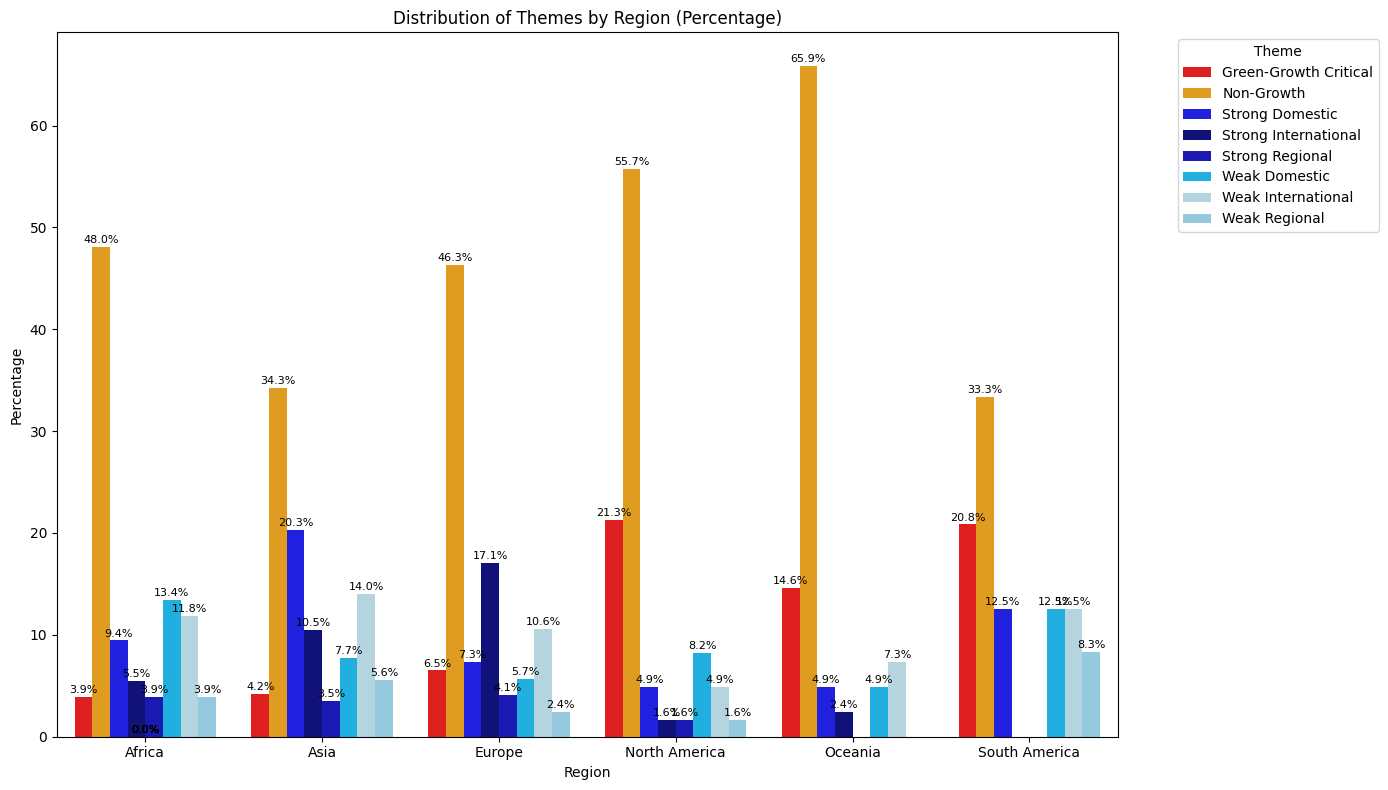

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('analysisdataset.csv')

# Split the combined themes and explode them into separate rows
df['Theme_Combined'] = df['Theme_Combined'].str.split()
df_exploded = df.explode('Theme_Combined')

# Define a mapping for full names of themes and their corresponding colors
theme_full_names = {
    'S_int': 'Strong International',
    'S_reg': 'Strong Regional',
    'S_dom': 'Strong Domestic',
    'W_int': 'Weak International',
    'W_reg': 'Weak Regional',
    'W_dom': 'Weak Domestic',
    'AG': 'Green-Growth Critical',
    'NG': 'Non-Growth'
}

theme_colors = {
    'Strong International': 'darkblue',
    'Strong Regional': 'mediumblue',
    'Strong Domestic': 'blue',
    'Weak International': 'lightblue',
    'Weak Regional': 'skyblue',
    'Weak Domestic': 'deepskyblue',
    'Green-Growth Critical': 'red',
    'Non-Growth': 'orange'
}

# Replace short theme names with full names
df_exploded['Theme_Combined'] = df_exploded['Theme_Combined'].map(theme_full_names)

# Count occurrences of each theme for each region
theme_counts = df_exploded.groupby(['Region', 'Theme_Combined']).size().reset_index(name='Count')

# Calculate total counts per region for percentage calculation
region_totals = theme_counts.groupby('Region')['Count'].sum().reset_index(name='Total')

# Merge total counts with theme counts
theme_counts = theme_counts.merge(region_totals, on='Region')

# Calculate percentage
theme_counts['Percentage'] = (theme_counts['Count'] / theme_counts['Total']) * 100

# Plotting the data
plt.figure(figsize=(14, 8))

# Create a grouped bar plot with specified colors
sns.barplot(
    data=theme_counts,
    x='Region',
    y='Percentage',
    hue='Theme_Combined',
    palette=theme_colors
)

# Add title and labels
plt.title('Distribution of Themes by Region (Percentage)')
plt.xlabel('Region')
plt.ylabel('Percentage')

# Annotate bars with exact percentages
for p in plt.gca().patches:
    height = p.get_height()
    plt.annotate(f'{height:.1f}%', 
                 (p.get_x() + p.get_width() / 2., height), 
                 ha='center', va='center', fontsize=8, color='black', 
                 xytext=(0, 5), textcoords='offset points')

plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Chi-squared: 89.45179253623678
P-value: 1.1727372000797099e-06
Degrees of Freedom: 35
There are statistically significant differences in the distribution of themes across regions.
Residuals (standardized):
Region                   Africa      Asia    Europe  North America   Oceania  \
Theme_Combined                                                                 
Green-Growth Critical -1.702380 -1.698919 -0.686262       3.534564  1.412360   
Non-Growth             0.427734 -1.987280  0.142988       1.188992  1.935342   
Strong Domestic       -0.582026  3.256779 -1.280012      -1.461914 -1.206189   
Strong International  -1.208896  0.738713  3.164800      -1.864963 -1.355070   
Strong Regional        0.548230  0.281726  0.620399      -0.642107 -1.124264   
Weak Domestic          1.804634 -0.397264 -1.122194      -0.125671 -0.824692   
Weak International     0.281689  1.083730 -0.138398      -1.429273 -0.708242   
Weak Regional          0.162633  1.208435 -0.708242      -0.825191 -1.2251

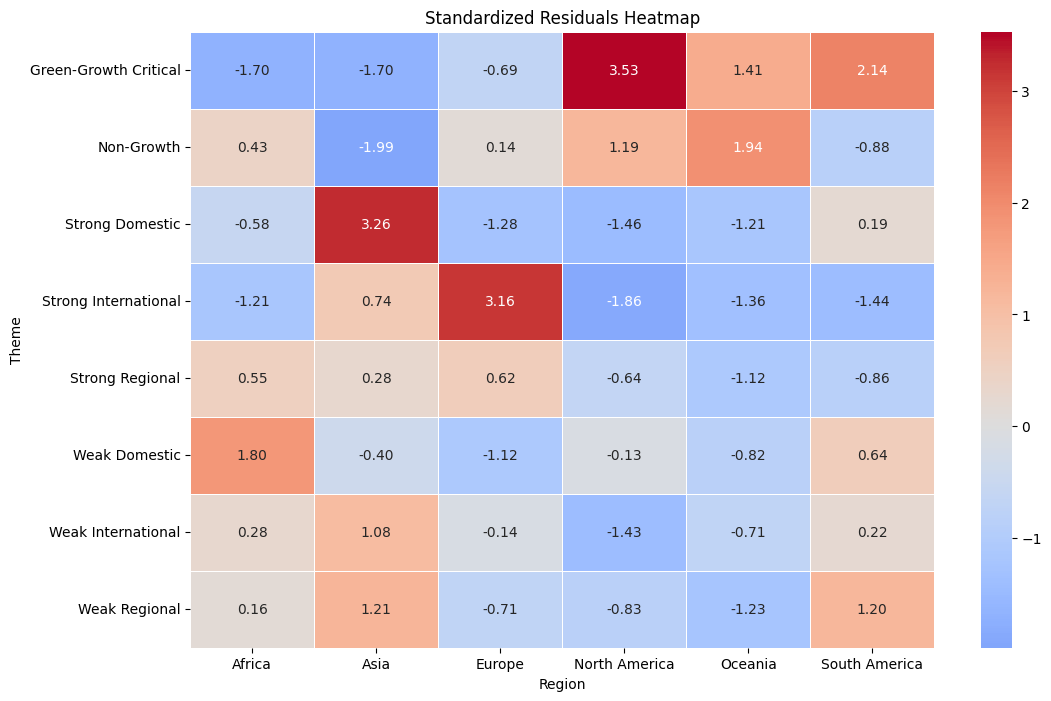

In [12]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('analysisdataset.csv')

# Split the combined themes and explode them into separate rows
df['Theme_Combined'] = df['Theme_Combined'].str.split()
df_exploded = df.explode('Theme_Combined')

# Define a mapping for full names of themes
theme_full_names = {
    'S_int': 'Strong International',
    'S_reg': 'Strong Regional',
    'S_dom': 'Strong Domestic',
    'W_int': 'Weak International',
    'W_reg': 'Weak Regional',
    'W_dom': 'Weak Domestic',
    'AG': 'Green-Growth Critical',
    'NG': 'Non-Growth'
}

# Replace short theme names with full names
df_exploded['Theme_Combined'] = df_exploded['Theme_Combined'].map(theme_full_names)

# Create a contingency table
contingency_table = pd.crosstab(df_exploded['Theme_Combined'], df_exploded['Region'])

# Perform the chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Output the results
print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")

# Check for significant results
alpha = 0.05
if p < alpha:
    print("There are statistically significant differences in the distribution of themes across regions.")
else:
    print("There are no statistically significant differences in the distribution of themes across regions.")

# Identify which themes are more common in which regions (post-hoc analysis)
observed = contingency_table.values
expected = expected.astype(float)  # Convert to float to handle division
residuals = np.zeros_like(observed, dtype=float)

# Calculate residuals with proper handling of zeros
for i in range(observed.shape[0]):
    for j in range(observed.shape[1]):
        if expected[i, j] != 0:
            residuals[i, j] = (observed[i, j] - expected[i, j]) / np.sqrt(expected[i, j])
        else:
            residuals[i, j] = np.nan

# Convert residuals to DataFrame for better readability
residuals_df = pd.DataFrame(residuals, index=contingency_table.index, columns=contingency_table.columns)

print("Residuals (standardized):")
print(residuals_df)

# Identify statistically significant cells
significant_cells = (residuals_df > 2) | (residuals_df < -2)

print("Significant cells (standardized residuals > 2 or < -2):")
print(significant_cells)

# Annotate significant cells on a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(residuals_df, annot=True, cmap='coolwarm', center=0, 
            annot_kws={"size": 10}, linewidths=0.5, fmt=".2f", mask=significant_cells.isnull())
plt.title('Standardized Residuals Heatmap')
plt.xlabel('Region')
plt.ylabel('Theme')
plt.show()
